In [1]:
import os
import copy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from image_segmentation import *
%load_ext autoreload
%autoreload 2

In [40]:
images = []
for dir in os.listdir("data/train"):
    print(dir)
    for image in os.listdir(os.path.join("data/train", dir)):
        img = np.array(Image.open(os.path.join("data/train", dir, image)))
        images.append((image[:-4], img))

4. neutral_bg_outliers
3. hand
2. noisy_bg
5. noisy_bg_outliers
6. hand_outliers
1. neutral_bg


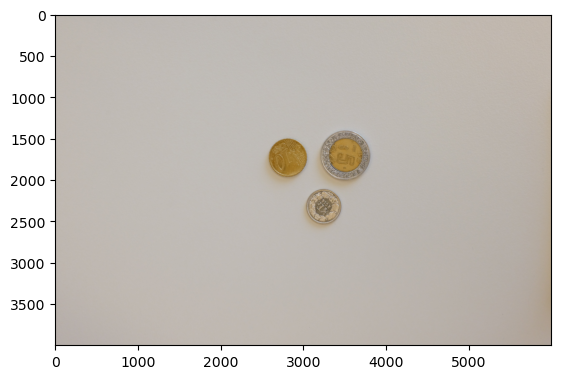

In [41]:
# Show first image

plt.imshow(images[0][1])

# Image segmentation

First we do a small example with the image 60

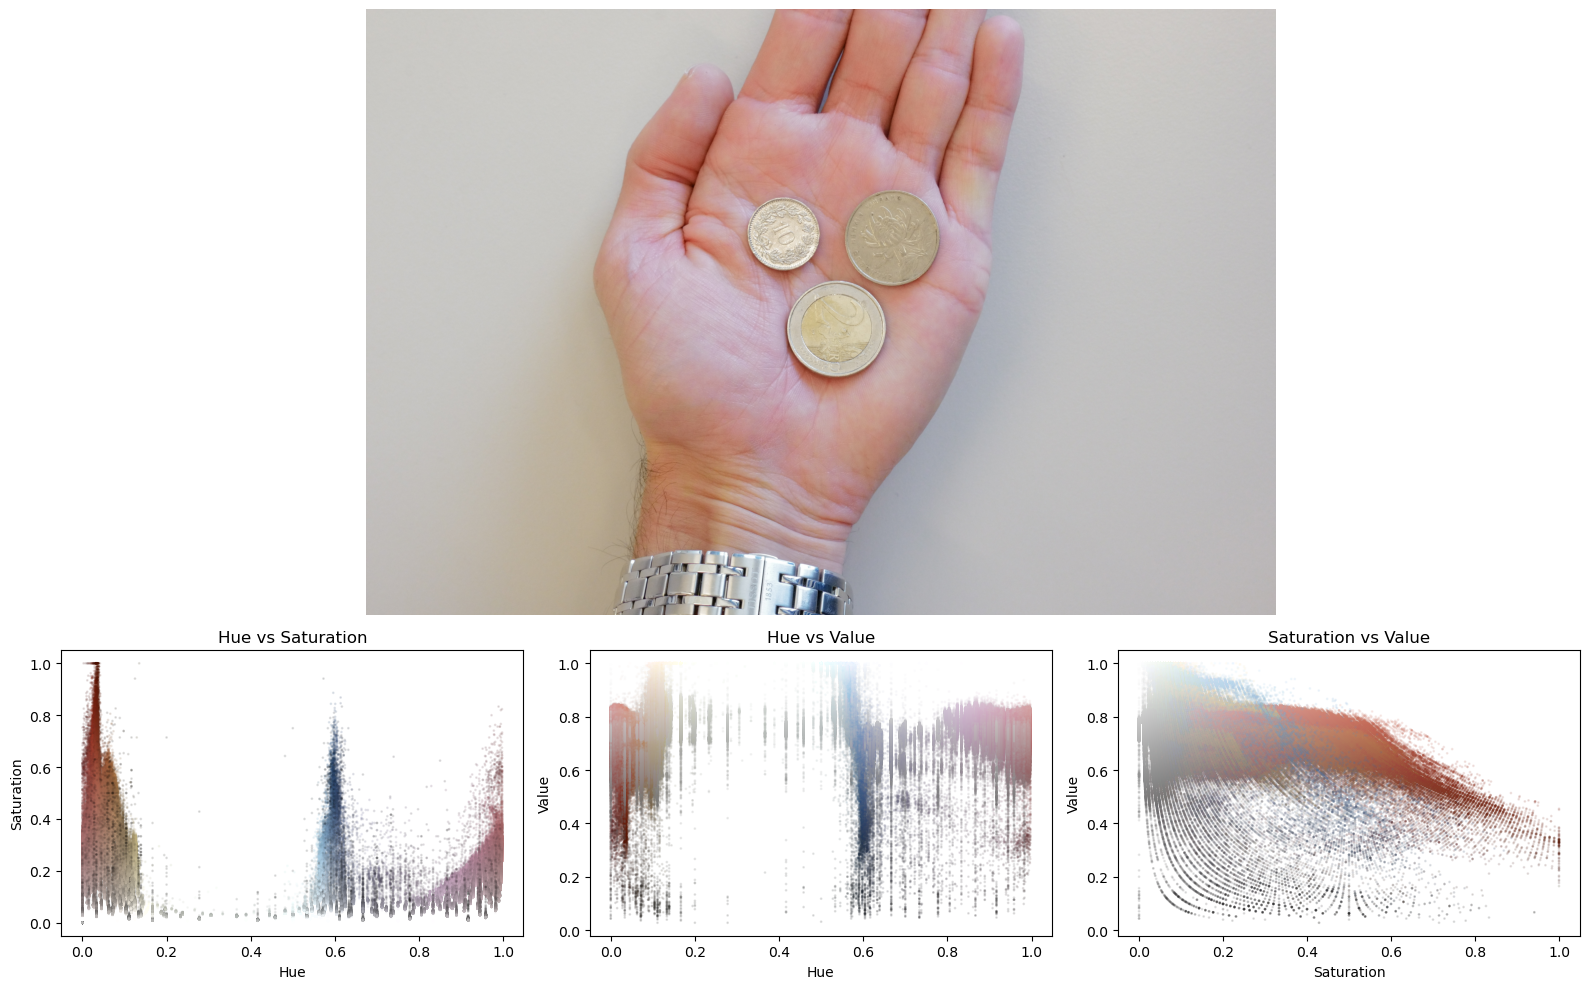

In [22]:
img_he = images[60][1]

plot_colors_histo(
    img = img_he,
    func = extract_hsv_channels,
    labels = ["Hue", "Saturation", "Value"],
)

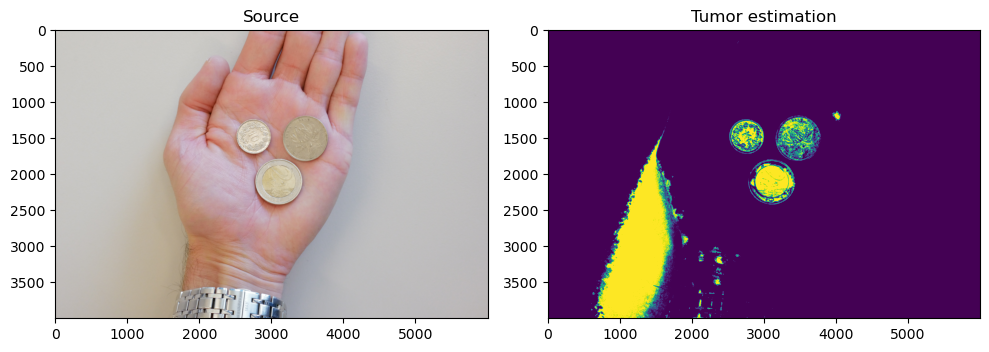

In [26]:
img_he = images[60][1]
plot_morphology_best(
    img_source=img_he,
    img_best=(apply_hsv_threshold(img_he)),
)

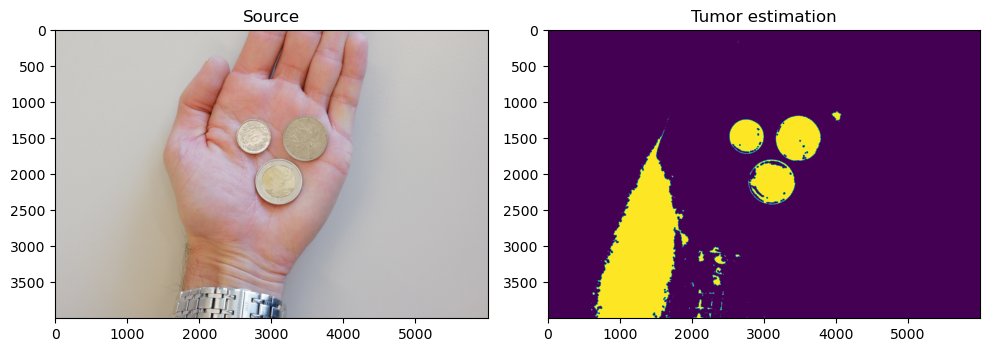

In [27]:
img_he = images[60][1]
plot_morphology_best(
    img_source=img_he,
    img_best=apply_morphology(apply_hsv_threshold(img_he)),
)

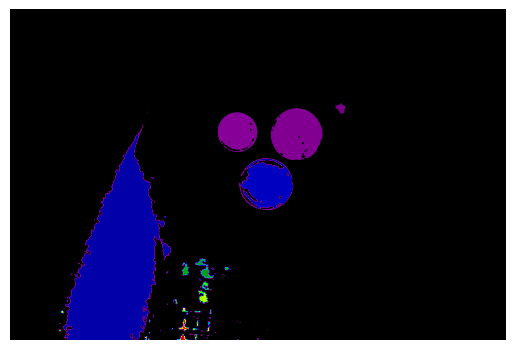

In [31]:
from skimage.measure import label, regionprops
filtered_image = apply_morphology(apply_hsv_threshold(img_he))
labeled_image = label(apply_morphology(apply_hsv_threshold(img_he)))
fig, ax = plt.subplots()
ax.imshow(labeled_image, cmap='nipy_spectral')
ax.axis('off')
plt.show()

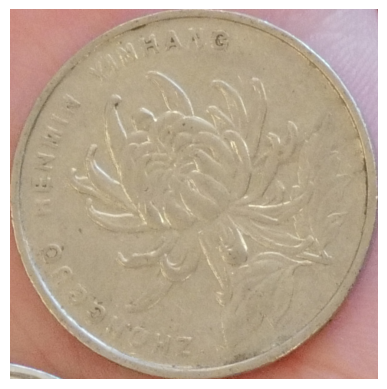

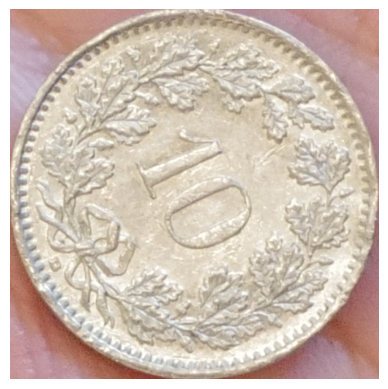

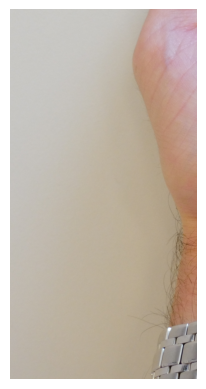

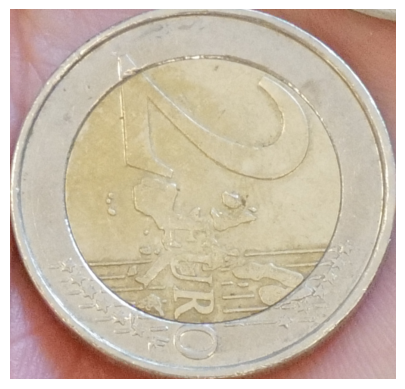

In [33]:
# Analyze each region (coin)
for region in regionprops(labeled_image):
    # Skip small areas that might be noise
    if region.area >= 100000:  # You can adjust this threshold based on your specific case
        minr, minc, maxr, maxc = region.bbox
        # You can extract each coin using slicing
        coin = img_he[minr:maxr, minc:maxc]
        
        # Optionally, display each coin
        fig, ax = plt.subplots()
        ax.imshow(coin, cmap='gray')
        ax.axis('off')
        plt.show()

Now we need to apply this to every image in the training set.

The final format is : (image_name, [list of different patches of potential coins])

In [45]:
if not os.path.exists("segmented_images.npy"):
    final_images = []
    for image in images:
        # Apply segmentation
        img_segmented = apply_morphology(apply_hsv_threshold(image[1]))

        # Let skimage do the region growing
        labeled_image = label(img_segmented)
        
        coins = [] # Potential coins detected by segmentation
        for region in regionprops(labeled_image):
            if region.area >= 100000:  # Filter out noise
                minr, minc, maxr, maxc = region.bbox
                
                coin = image[1][minr:maxr, minc:maxc]
                coins.append(coin)

        final_images.append((image[0], coins))

We will save the resulting np array in memory so that we don't have to run the file each time

In [62]:
if not os.path.exists("segmented_images.npy"):
    np_final_images = np.array(final_images, dtype=object)
    with open('segmented_images.npy', 'wb') as f:
        np.save(f, np_final_images)

In [66]:
if os.path.exists("segmented_images.npy"):
    with open('segmented_images.npy', 'rb') as f:
        np_final_images = np.load(f, allow_pickle=True)


# Coin classification

We have coins and non coins images that we need to classify.